In [29]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

#Lab 6 Assignment – Feedforward Neural Network on Insurance Premium Dataset

##Dataset: [Insurance Premium (OpenML ID 43463](https://www.openml.org/search?type=data&status=active&id=43463)

##Total Marks: 20

###Q1. Load and Inspect Dataset (2 marks)

Load the Insurance Premium dataset from OpenML. Check for: Missing features and duplicate entries.


In [30]:
import pandas as pd
from sklearn.datasets import fetch_openml

In [31]:
df = fetch_openml(data_id=43463, as_frame=True)


In [32]:
df= pd.DataFrame(df.data)

In [33]:
data = df.drop(columns = 'charges')
target = df['charges']

In [34]:
data.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest



###Q2. Dataset Splitting (2 marks)

Split the dataset into train (70%), validation (15%), and test (15%).

In [35]:
train_x,temp_x,train_y,temp_y = train_test_split(data,target,test_size=0.3,random_state=42)
test_x,val_x,test_y,val_y = train_test_split(temp_x,temp_y,test_size=0.5,random_state=42)

###Q3. Feature Preprocessing (2 marks)

Perform feature scaling (e.g., MinMax scaling or Standardization) so all numerical features are in the same range. Encode categorical features like region using One-Hot Encoding.


In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_cols = ['age', 'bmi', 'children']
train_x = pd.get_dummies(train_x, columns=['sex', 'smoker', 'region'])
val_x = pd.get_dummies(val_x, columns=['sex', 'smoker', 'region'])
test_x = pd.get_dummies(test_x, columns=['sex', 'smoker', 'region'])
train_x[numerical_cols] = scaler.fit_transform(train_x[numerical_cols])
val_x[numerical_cols] = scaler.transform(val_x[numerical_cols])
test_x[numerical_cols] = scaler.transform(test_x[numerical_cols])



In [37]:
scaler1 = MinMaxScaler()
train_y = scaler1.fit_transform(train_y.values.reshape(-1, 1))
val_y = scaler1.transform(val_y.values.reshape(-1, 1))
test_y = scaler1.transform(test_y.values.reshape(-1, 1))


In [38]:
#converting booleans to float
train_x = train_x.astype(float)
val_x = val_x.astype(float)
test_x = test_x.astype(float)




In [39]:
train_x.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
332,0.934783,0.408932,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
355,0.608696,0.313156,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
138,0.782609,0.428840,0.6,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
381,0.804348,0.396153,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
292,0.152174,0.795803,0.4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


###Q4. Implement Feedforward Neural Network (5 marks)

1. Implement a feedforward neural network from scratch (NumPy).
2. Use number of hidden layers and neurons per layer as hyperparameters.
3. Use MSE as the loss function.
4. Train using Mini-batch Gradient Descent.
5. Choose a suitable learning rate and batch size.

In [50]:
import numpy as np

class SimpleNN:
    def __init__(self, input_size, hidden_sizes, output_size, lr=0.0001, epochs=1000, batch_size=64):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Initialize weights and biases
        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(layer_sizes) - 1):
          fan_in = layer_sizes[i]
          fan_out = layer_sizes[i + 1]
          stddev = np.sqrt(6 / (fan_in + fan_out))
          self.weights.append(np.random.uniform(-stddev,stddev,(layer_sizes[i], layer_sizes[i+1])))
          self.biases.append(np.zeros((1, layer_sizes[i+1])))


    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        # to avoid overflow
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, X):
        activations = [X]
        #Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.sigmoid(z)
            activations.append(a)

        # Output layer (no activatio)
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        activations.append(z)
        return activations

    def backward(self, y, activations):
        m = y.shape[0]
        grads_W = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        # For MSE loss,the derivative is 2*(y_pred-y_true)
        delta = activations[-1] - y.reshape(-1, 1)
        # gradients forlast layer
        grads_W[-1] = np.dot(activations[-2].T, delta) / m
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m
        # Propagate backwards
        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            grads_W[i] = np.dot(activations[i].T, delta) / m
            grads_b[i] = np.sum(delta, axis=0, keepdims=True) / m

        return grads_W, grads_b

    def fit(self, X, y, X_val=None, y_val=None):
        self.train_losses = []
        self.val_losses = []

        for epoch in range(self.epochs):
            epoch_losses = []
            # batch gradient descent
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                activations = self.forward(X_batch)
                grads_W, grads_b = self.backward(y_batch, activations)
                # Updating  weights and biases
                for j in range(len(self.weights)):
                    self.weights[j] -= self.lr * grads_W[j]
                    self.biases[j] -= self.lr * grads_b[j]
            # Calculate and store loss for the epoch
            y_pred_train = self.forward(X)[-1]
            train_loss = self.mse_loss(y, y_pred_train)
            self.train_losses.append(train_loss)

            if X_val is not None and y_val is not None:
                y_pred_val = self.forward(X_val)[-1]
                val_loss = self.mse_loss(y_val, y_pred_val)
                self.val_losses.append(val_loss)
                if (epoch + 1) % 100 == 0:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            else:
                 if (epoch + 1) % 100 == 0:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}")


    def predict(self, X):
        return self.forward(X)[-1].flatten()

    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true.reshape(-1, 1) - y_pred)**2)


###Q5. Hyperparameter Tuning (2 marks)

Tune the number of hidden layers and neurons per layer on the validation set.
Try the following combinations:
1. Neurons in a layer: [32,64,128]
2. Number of hidden layers: [2,3]

Pick learning rate and batch size as per your choice.

In [52]:
# iterate
lr = 1e-2
batch_size = 128
best_val_loss = float('inf')
best_num_hidden = -1
best_num_neurons = -1

for num_hidden_layers in [2,3]:
    for num_neurons in [32,64,128]:
        model = SimpleNN(hidden_sizes=[num_neurons] * num_hidden_layers, input_size=train_x.shape[1], output_size=1, lr=lr, epochs=3000, batch_size=batch_size)
        model.fit(train_x.values, train_y, val_x.values, val_y)
        train_loss = model.mse_loss(train_y, model.forward(train_x.values)[-1])
        val_loss = model.mse_loss(val_y, model.forward(val_x.values)[-1])
        print(f"Hidden Layers: {num_hidden_layers}, Neurons: {num_neurons}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_num_hidden = num_hidden_layers
            best_num_neurons = num_neurons

print(f"Best Hyperparameters based on Validation Loss:")
print(f"Number of Hidden Layers: {best_num_hidden}")
print(f"Number of Neurons per Layer: {best_num_neurons}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Epoch 100/3000, Train Loss: 0.0390, Val Loss: 0.0401
Epoch 200/3000, Train Loss: 0.0368, Val Loss: 0.0379
Epoch 300/3000, Train Loss: 0.0348, Val Loss: 0.0357
Epoch 400/3000, Train Loss: 0.0328, Val Loss: 0.0337
Epoch 500/3000, Train Loss: 0.0309, Val Loss: 0.0316
Epoch 600/3000, Train Loss: 0.0290, Val Loss: 0.0296
Epoch 700/3000, Train Loss: 0.0271, Val Loss: 0.0276
Epoch 800/3000, Train Loss: 0.0253, Val Loss: 0.0256
Epoch 900/3000, Train Loss: 0.0235, Val Loss: 0.0237
Epoch 1000/3000, Train Loss: 0.0218, Val Loss: 0.0219
Epoch 1100/3000, Train Loss: 0.0203, Val Loss: 0.0202
Epoch 1200/3000, Train Loss: 0.0189, Val Loss: 0.0187
Epoch 1300/3000, Train Loss: 0.0176, Val Loss: 0.0174
Epoch 1400/3000, Train Loss: 0.0165, Val Loss: 0.0162
Epoch 1500/3000, Train Loss: 0.0156, Val Loss: 0.0152
Epoch 1600/3000, Train Loss: 0.0149, Val Loss: 0.0144
Epoch 1700/3000, Train Loss: 0.0143, Val Loss: 0.0137
Epoch 1800/3000, Train Loss: 0.0138, Val Loss: 0.0132
Epoch 1900/3000, Train Loss: 0.0133, 


###Q6. Training & Validation Curves (2 marks)

For the best hyperparameters, plot the training and validation loss vs. epochs.

In [53]:
# lets plot the curve
# Re-train the model with best hyperparameters to get the loss history
best_model = SimpleNN(hidden_sizes=[best_num_neurons] * best_num_hidden, input_size=train_x.shape[1], output_size=1, lr=lr, epochs=3000, batch_size=batch_size)
best_model.fit(train_x.values, train_y, val_x.values, val_y)



Epoch 100/3000, Train Loss: 0.0365, Val Loss: 0.0377
Epoch 200/3000, Train Loss: 0.0339, Val Loss: 0.0349
Epoch 300/3000, Train Loss: 0.0314, Val Loss: 0.0323
Epoch 400/3000, Train Loss: 0.0290, Val Loss: 0.0298
Epoch 500/3000, Train Loss: 0.0267, Val Loss: 0.0273
Epoch 600/3000, Train Loss: 0.0245, Val Loss: 0.0250
Epoch 700/3000, Train Loss: 0.0224, Val Loss: 0.0228
Epoch 800/3000, Train Loss: 0.0205, Val Loss: 0.0208
Epoch 900/3000, Train Loss: 0.0188, Val Loss: 0.0189
Epoch 1000/3000, Train Loss: 0.0173, Val Loss: 0.0173
Epoch 1100/3000, Train Loss: 0.0160, Val Loss: 0.0159
Epoch 1200/3000, Train Loss: 0.0150, Val Loss: 0.0148
Epoch 1300/3000, Train Loss: 0.0141, Val Loss: 0.0139
Epoch 1400/3000, Train Loss: 0.0135, Val Loss: 0.0132
Epoch 1500/3000, Train Loss: 0.0130, Val Loss: 0.0127
Epoch 1600/3000, Train Loss: 0.0126, Val Loss: 0.0123
Epoch 1700/3000, Train Loss: 0.0123, Val Loss: 0.0120
Epoch 1800/3000, Train Loss: 0.0121, Val Loss: 0.0117
Epoch 1900/3000, Train Loss: 0.0119, 

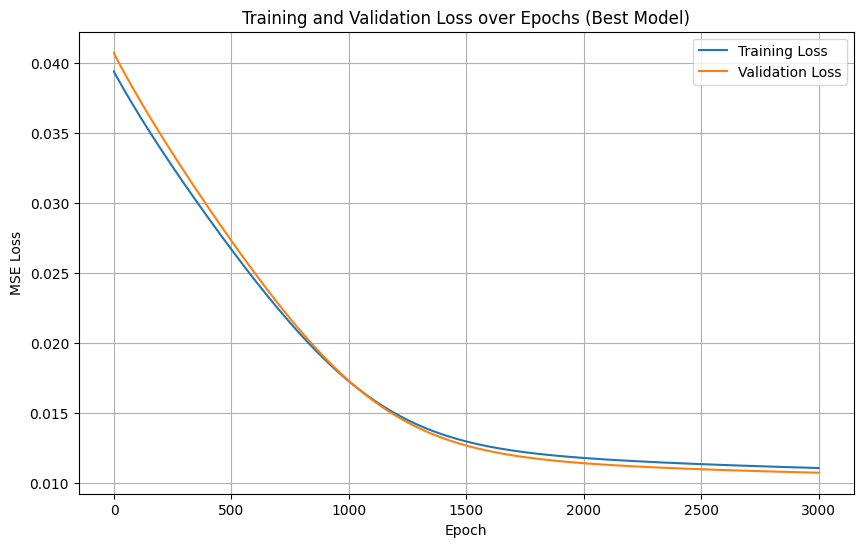

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(best_model.train_losses, label='Training Loss')
plt.plot(best_model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

###Q7. Model Evaluation – Custom NN (2 marks)

1. On the test set, report MSE and R² Score, round predictions to nearest integers.

2. Show a scatter plot of predictions vs ground truth targets.

Custom NN Performance (Test Set):
MSE: 33728853.85370604
R² Score: 0.7609107468887032


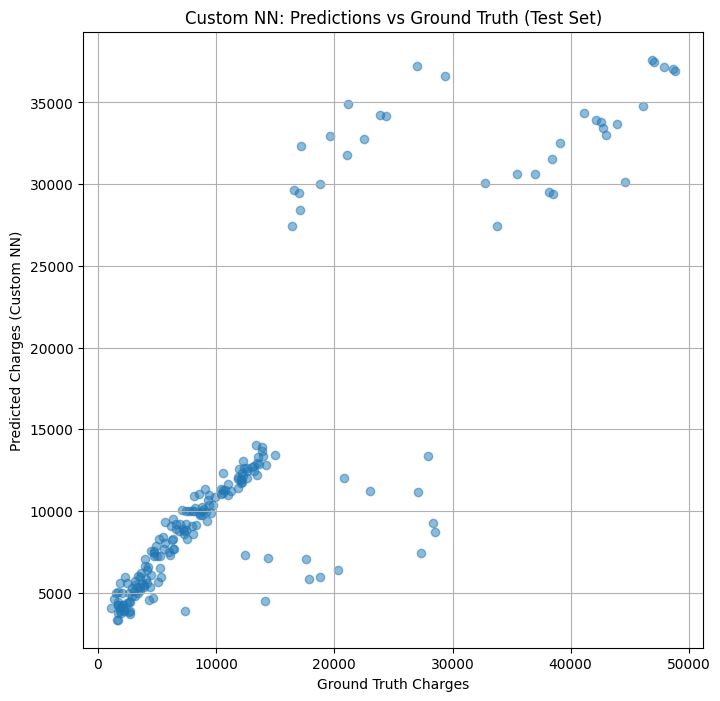

In [55]:
# Evaluate custom NN on the test set

y_pred_test_scaled = best_model.predict(test_x.values)
y_pred_test = scaler1.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler1.inverse_transform(test_y).flatten()

# Round predictions to nearest integers
y_pred_test_rounded = np.round(y_pred_test)

mse_custom = mean_squared_error(y_test_unscaled, y_pred_test_rounded)
r2_custom = r2_score(y_test_unscaled, y_pred_test_rounded)

print("Custom NN Performance (Test Set):")
print("MSE:", mse_custom)
print("R² Score:", r2_custom)

# Scatter plot of predictions vs ground truth
plt.figure(figsize=(8, 8))
plt.scatter(y_test_unscaled, y_pred_test_rounded, alpha=0.5)
plt.xlabel("Ground Truth Charges")
plt.ylabel("Predicted Charges (Custom NN)")
plt.title("Custom NN: Predictions vs Ground Truth (Test Set)")
plt.grid(True)
plt.show()

###Q8. Sklearn MLPRegressor (3 marks)

1. Train MLPRegressor with the same hyperparameters and report test set performance
(MSE, R² Score).
2. Compare its performace with custom NN.
3. Show scatter plot of predictions vs ground truths.


Sklearn MLPRegressor Performance (Test Set):
MSE: 20343384.00509255
R² Score: 0.8557945517914642

Performance Comparison (Test Set):
Custom NN MSE: 33728853.8537, R²: 0.7609
Sklearn MLPRegressor MSE: 20343384.0051, R²: 0.8558


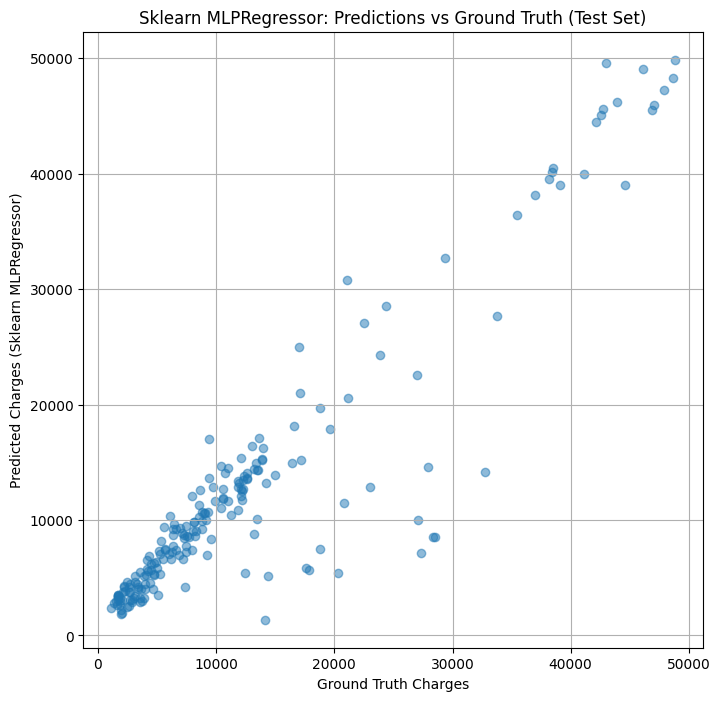

In [56]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

hidden_layer_sizes_sklearn = tuple([best_num_neurons] * best_num_hidden)

sklearn_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes_sklearn,
                           max_iter=3000,
                           random_state=42,
                           learning_rate_init=lr, #use same learning rate
                           batch_size=batch_size,  #use same batch size
                           early_stopping=False)

sklearn_model.fit(train_x.values, train_y.ravel()) # .ravel() to convert y to 1D array


# Evaluate on test set
y_pred_test_sklearn_scaled = sklearn_model.predict(test_x.values)
y_pred_test_sklearn = scaler1.inverse_transform(y_pred_test_sklearn_scaled.reshape(-1, 1)).flatten()

# Round predictions to nearest integers
y_pred_test_sklearn_rounded = np.round(y_pred_test_sklearn)


test_mse_sklearn = mean_squared_error(y_test_unscaled, y_pred_test_sklearn_rounded)
test_r2_sklearn = r2_score(y_test_unscaled, y_pred_test_sklearn_rounded)

print("\nSklearn MLPRegressor Performance (Test Set):")
print("MSE:", test_mse_sklearn)
print("R² Score:", test_r2_sklearn)

# Compare performance
print("\nPerformance Comparison (Test Set):")
print(f"Custom NN MSE: {mse_custom:.4f}, R²: {r2_custom:.4f}")
print(f"Sklearn MLPRegressor MSE: {test_mse_sklearn:.4f}, R²: {test_r2_sklearn:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(y_test_unscaled, y_pred_test_sklearn_rounded, alpha=0.5)
plt.xlabel("Ground Truth Charges")
plt.ylabel("Predicted Charges (Sklearn MLPRegressor)")
plt.title("Sklearn MLPRegressor: Predictions vs Ground Truth (Test Set)")
plt.grid(True)
plt.show()